In [ ]:
!pip uninstall tensorflow -y
!pip uninstall tensorflow-gpu -y

In [ ]:
!pip install tensorflow==2.5.0

In [ ]:
!pip install seaborn

In [1]:
import os, h5py
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import load_model

from track import SOLAR_LOGG, SOLAR_TEFF, SOLAR_ZX

print('tensorflow ==', tf.__version__)

%matplotlib inline

tensorflow == 2.5.0


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
# tf.device('XLA_GPU')

In [4]:
name = 'model_2'

In [5]:
path = '/fast/extended_grid.h5'
h5f = h5py.File(path, 'r')
data = np.array(h5f['data'])
columns = np.array([v.decode() for v in h5f['label']])
h5f.close()

In [6]:
mask = [True, False, True, True, True, True, False, True, True, True, False, False, False, False]

In [7]:
df = pd.DataFrame(data[:,mask], columns=columns[mask])
# del data

In [8]:
columns

array(['M/Msun', 'Age(Gyr)', '[Fe/H]', 'fk', 'Rocrit', 'alphaMLT',
       'Prot(days)', 'log(Teff)(K)', 'L/Lsun', 'R/Rsun', 'Xcore',
       'Z/X(surface)', 'rho(g/cm3)', 'Lnuc/Lsun'], dtype='<U12')

In [9]:
# df.head()

In [10]:
df['log(R/Rsun)'] = np.log10(data[:,9])
df['log(Age)(Gyr)'] = np.log10(data[:,1])
df['log(Prot)(days)'] = np.log10(data[:,6])
df['[Fe/H](surface)'] = np.log10(data[:,11]) - np.log10(SOLAR_ZX)
df['log(L/Lsun)'] = 2 * np.log10(data[:,9]) + 4 * (data[:,7] - np.log10(SOLAR_TEFF))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
df.head()

,M/Msun,[Fe/H],fk,Rocrit,alphaMLT,log(Teff)(K),L/Lsun,R/Rsun,log(R/Rsun),log(Age)(Gyr),log(Prot)(days),[Fe/H](surface),log(L/Lsun)
0,0.84,0.3,5.0,1.0,1.9,3.688180,0.324316,0.798693,-0.097620,-1.313376,-0.428920,0.297812,-0.489031
1,0.84,0.3,5.0,1.0,1.9,3.688562,0.324846,0.797936,-0.098032,-1.311463,-0.429933,0.297810,-0.488322
2,0.84,0.3,5.0,1.0,1.9,3.688946,0.325326,0.797118,-0.098477,-1.309463,-0.430962,0.297809,-0.487680
3,0.84,0.3,5.0,1.0,1.9,3.689318,0.325737,0.796255,-0.098948,-1.307418,-0.431983,0.297807,-0.487132
4,0.84,0.3,5.0,1.0,1.9,3.689687,0.326076,0.795318,-0.099459,-1.305274,-0.433018,0.297806,-0.486681


In [12]:
mask = data[:,6] == 0
del data

In [13]:
df_ = df.drop(df.loc[mask].index)
del df

In [14]:
# df.drop(columns=['rho(g/cm3)','Xcore', 'Lnuc/Lsun'], inplace=True)

In [15]:
# df['log(R/Rsun)'] = np.log10(df['R/Rsun'])
# df.drop(columns=['R/Rsun'], inplace=True)

In [16]:
# df['log(g)'] = SOLAR_LOGG + np.log10(df['M/Msun']) - 2 * df['log(R/Rsun)']
# df['log(L/Lsun)'] = 2 * df['log(R/Rsun)'] + 4 * (df['log(Teff)(K)'] - np.log10(SOLAR_TEFF))
# df['[Fe/H](surface)'] = np.log10(df['Z/X(surface)']) - np.log10(SOLAR_ZX)
# df.drop(columns=['Z/X(surface)'], inplace=True)

In [17]:
# df['log(Prot)(days)'] = np.log10(df['Prot(days)'])
# df.drop(columns=['Prot(days)'], inplace=True)

In [18]:
# df['log(Age)(Gyr)'] = np.log10(df['Age(Gyr)'])
# df.drop(columns=['Age(Gyr)'], inplace=True)

In [19]:
# non_diff = df.loc[df['EEP'] == 1, '[Fe/H](surface)'].to_numpy() == df.loc[df['EEP'] == 2, '[Fe/H](surface)'].to_numpy()
# np.sum(non_diff)

In [20]:
# start = df.loc[df['EEP'] == 1, '[Fe/H](surface)'].index.to_numpy()
# stop = df.loc[df['EEP'] == 3, '[Fe/H](surface)'].index.to_numpy()

In [21]:
# non_diff_idx = np.concatenate([np.arange(st, sp+1, dtype=int) for st, sp in zip(start[non_diff], stop[non_diff])])

In [22]:
# len(non_diff_idx) / len(df)

In [23]:
# len(df) - len(non_diff_idx)

In [24]:
# df.drop(non_diff_idx, inplace=True)

In [25]:
# len(df)

In [26]:
# df2 = df.drop(columns=['R/Rsun', 'Xcore', 'Lnuc/Lsun', 'Z/X(surface)', 'L/Lsun', 'Prot(days)'])
# del df

In [27]:
# df2.head()

In [28]:
random_state = 2

train = df_.sample(frac=0.8, random_state=random_state)
test = df_.drop(train.index)

In [29]:
print('Train length = ', len(train))
print('Test length = ', len(test))

Train length =  98592000
Test length =  24648000


In [30]:
del df_

In [31]:
input_cols = ['log(Age)(Gyr)', 'M/Msun', '[Fe/H]', 'alphaMLT', 'fk', 'Rocrit']
output_cols = ['log(Teff)(K)', 'log(R/Rsun)', '[Fe/H](surface)', 'log(Prot)(days)']

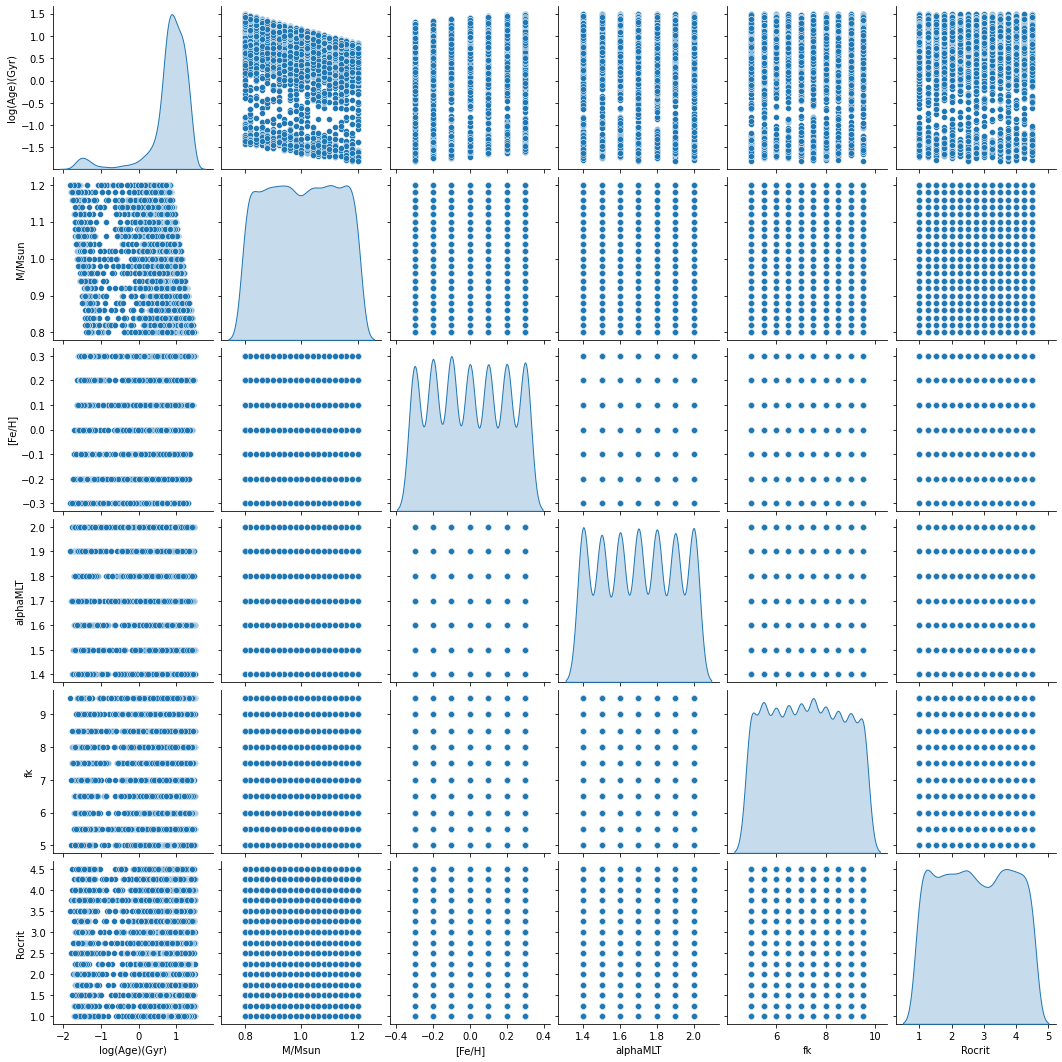

In [32]:
sns.pairplot(train[input_cols].sample(10000), diag_kind='kde');

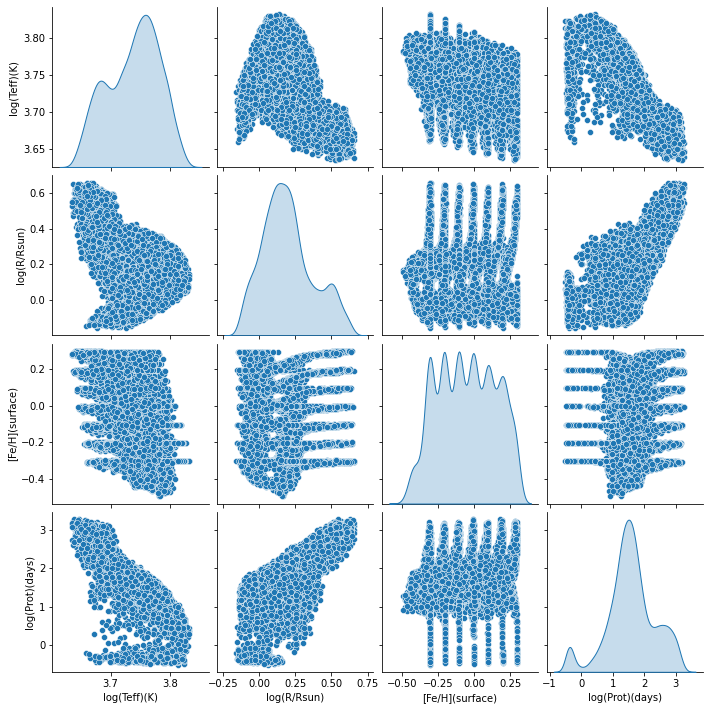

In [33]:
sns.pairplot(train[output_cols].sample(10000), diag_kind='kde');

In [34]:
input_normalizer = preprocessing.Normalization()
input_normalizer.adapt(train[input_cols].to_numpy())

In [35]:
input_mean = input_normalizer.mean.numpy()
input_var = input_normalizer.variance.numpy()
for col, mean, var in zip(input_cols, input_mean, input_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

log(Age)(Gyr)  : 7.790e-01, 3.626e-01
M/Msun         : 9.977e-01, 1.434e-02
[Fe/H]         : 9.634e-05, 3.993e-02
alphaMLT       : 1.691e+00, 3.996e-02
fk             : 7.333e+00, 2.032e+00
Rocrit         : 2.752e+00, 1.167e+00


In [36]:
output_normalizer = preprocessing.Normalization()
output_normalizer.adapt(train[output_cols].to_numpy())

In [37]:
output_mean = output_normalizer.mean.numpy()
output_var = output_normalizer.variance.numpy()
for col, mean, var in zip(output_cols, output_mean, output_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

log(Teff)(K)   : 3.667e+00, 2.275e-03
log(R/Rsun)    : 1.941e-01, 2.965e-02
[Fe/H](surface): -5.237e-02, 3.989e-02
log(Prot)(days): 1.556e+00, 5.726e-01


In [38]:
output_rescaler = preprocessing.Rescaling(scale=np.sqrt(output_var), offset=output_mean)

In [39]:
# def build_model(n_neurons, n_hidden, activation='elu', l2_reg=0.0):
#     hidden_layers = [layers.Dense(n_neurons, 
#                                   activation=activation) for layer in range(n_hidden)]

#     all_layers = [input_normalizer] + hidden_layers + [layers.Dense(len(output_cols)), output_rescaler]
#     model = keras.Sequential(all_layers)
#     return model

In [40]:
def build_model(n_neurons, n_hidden, activation='elu', l2_reg=0.0):
    reg = regularizers.L2(l2_reg)
    hidden_layers = [layers.Dense(n_neurons, 
                                  activation=activation, 
                                  kernel_regularizer=reg) for layer in range(n_hidden)]
    all_layers = [input_normalizer] + hidden_layers + [layers.Dense(len(output_cols)), output_rescaler]
    model = keras.Sequential(all_layers)
    return model

In [41]:
model = build_model(128, 6, l2_reg=0.0)

In [42]:
model.save(f'models/{name}')

INFO:tensorflow:Assets written to: models/model_2/assets


In [43]:
learning_rate = 1e-4
momentum = 0.999

model.compile(loss='mean_squared_error',
#              optimizer=keras.optimizers.SGD(learning_rate, momentum=momentum),
             optimizer=keras.optimizers.Adam(learning_rate)
             )

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1

In [45]:
batch_size = 8191*2

print('Number of batches:', len(train)//batch_size)
print('Remainder:', len(train)%batch_size)

Number of batches: 6018
Remainder: 5124


In [ ]:
%%time
history = model.fit(
    train[input_cols], train[output_cols],
    validation_split=0.2,
    batch_size=batch_size,
    verbose=0, epochs=7500,
)

In [ ]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='validation loss')

plt.yscale('log')
plt.legend()

In [ ]:
model.save(f'models/{name}')

In [ ]:
pred = pd.DataFrame(model.predict(test[input_cols], batch_size=batch_size), columns=output_cols)
pred.head()

In [ ]:
truth = test[output_cols].reset_index(drop=True)
error = truth - pred
frac_error = (truth - pred) / truth

In [ ]:
truth.head()

In [ ]:
log_cols = ['log(Teff)(K)', 'log(R/Rsun)', 'log(Prot)(days)']

for col in log_cols:
    error[f'10^{col}'] = 10**truth[col] - 10**pred[col]
    frac_error[f'10^{col}'] = (10**truth[col] - 10**pred[col]) / 10**truth[col]

In [ ]:
error.head()

In [ ]:
error.mean()

In [ ]:
error.std()

In [ ]:
frac_error.mean()

In [ ]:
frac_error.std()

In [ ]:
from scipy import stats

In [ ]:
pd.Series(stats.median_abs_deviation(error), error.columns)

In [ ]:
pd.Series(stats.median_abs_deviation(frac_error), frac_error.columns)

In [ ]:
plt.plot(test['EEP'], 10**error['log(Prot)(days)'], '.');

In [ ]:
plt.plot(10**truth['log(Prot)(days)'], 10**error['log(Prot)(days)'], '.');

In [ ]:
plt.plot(10**truth['log(R/Rsun)'], 10**error['log(R/Rsun)'], '.');

In [ ]:
plt.plot(10**truth['log(Teff)(K)'], 10**error['log(Teff)(K)'], '.');

In [ ]:
ax = test.iloc[:5000].plot(x='log(Teff)(K)', y='log(L/Lsun)', c='M/Msun', cmap='viridis', kind='scatter')

ax.invert_xaxis();